In [17]:
import pandas as pd
import lightgbm as lgb
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from utils import set_figure_pixel_size
from sklearn.metrics import classification_report

df = pd.read_parquet('data/sample_7000_per_target_processed.parquet')
df

,text,generated,uniq_words_ratio,rare_word_frequency,modal_verb_patterns,subordinate_clause_ratio,transition_word_overuse,word_length_variance,mean_syllables_per_word,hedging_language_ratio,sentence_length_variance,mean_sentence_length,grammar_issues_per_100_words,function_word_ratio,punct_density,punct_diversity,mean_word_length
0,Based on LY experiences\n\nI agree with Emerso...,0.0,0.421769,16.304348,44.444444,74.509804,0.000000,4.412698,1.343537,2.040816,95.083333,24.500000,2.552553,0.513605,0.025592,0.100000,4.190476
1,Each year more people are killed by driving ac...,0.0,0.463131,45.480226,55.555556,75.581395,23.809524,6.886755,1.640362,1.034929,219.487528,36.809524,4.842474,0.442432,0.017410,0.075000,4.836999
2,"Yes, today most the people have cellphones any...",0.0,0.452153,13.333333,66.666667,72.972973,0.000000,3.782148,1.296651,3.110048,131.789474,22.000000,1.641138,0.538278,0.016941,0.081081,4.162679
3,"Distance learning was popular, and had so many...",0.0,0.450304,51.162791,33.333333,64.788732,0.000000,6.938453,1.559838,2.231237,48.201600,19.720000,6.549815,0.480730,0.014906,0.066667,5.026369
4,As the world changes and humans present more a...,0.0,0.543814,27.044025,22.222222,71.111111,0.000000,5.321032,1.409794,1.030928,135.775510,27.714286,4.800937,0.477922,0.017840,0.184211,4.402597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,"Dear [State Senator],\n\nI am writing to expr...",1.0,0.588435,58.878505,33.333333,62.857143,7.692308,7.595227,1.758503,2.380952,88.213018,22.692308,2.095808,0.448980,0.018857,0.235294,5.003401
13996,Seeking multiple opinions is beneficial when m...,1.0,0.592784,54.639175,11.111111,65.384615,0.000000,8.381762,1.675258,1.030928,62.469136,21.555556,3.424658,0.453608,0.017742,0.090909,5.268041
13997,There is no doubt that academic specialization...,1.0,0.401709,58.169935,22.222222,66.000000,23.529412,8.852769,1.581197,2.849003,46.463668,20.647059,4.627249,0.509972,0.015779,0.062500,4.672365
13998,"When making a choice, it is important to consi...",1.0,0.348235,58.426966,22.222222,69.230769,6.250000,7.644700,1.592941,2.117647,49.621094,26.562500,4.427646,0.461176,0.013285,0.090909,4.762353


[LightGBM] [Info] Number of positive: 4497, number of negative: 4463
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3462
[LightGBM] [Info] Number of data points in the train set: 8960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501897 -> initscore=0.007589
[LightGBM] [Info] Start training from score 0.007589
[100]	training's auc: 0.966713	training's l2: 0.0993659	training's binary_logloss: 0.363371	training's l1: 0.287563	valid_0's auc: 0.952847	valid_0's l2: 0.111252	valid_0's binary_logloss: 0.389091	valid_0's l1: 0.300582
[200]	training's auc: 0.973314	training's l2: 0.0683339	training's binary_logloss: 0.260873	training's l1: 0.197974	valid_0's auc: 0.957045	valid_0's l2: 0.085486	valid_0's binary_logloss: 0.302136	valid_0's l1: 0.217534
[300]	training's auc: 0.978328	training's l2: 0.0572409	training's bi

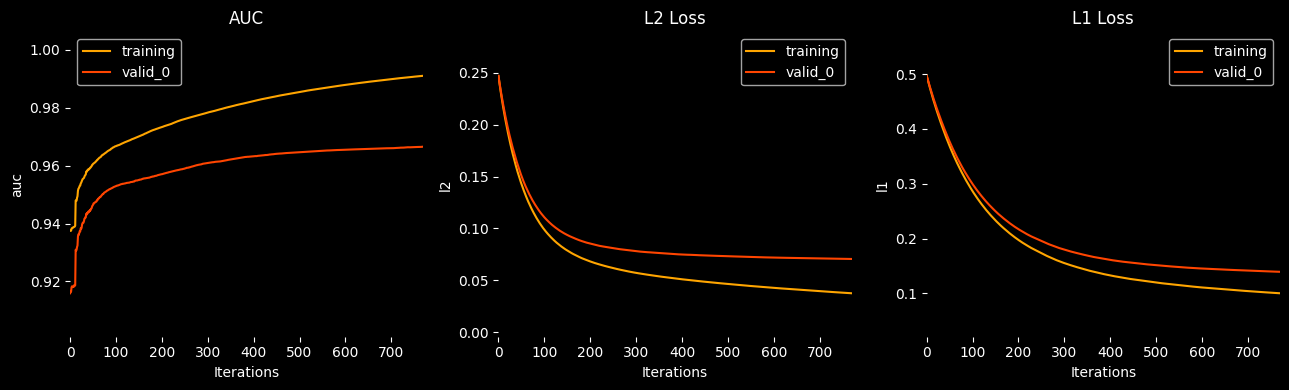

In [26]:
validation_df = df.sample(frac=0.2, random_state=1)
validation_y = validation_df['generated']
validation_df = validation_df.drop(columns=['generated', 'text'])

train_df = df.drop(validation_df.index)
X = train_df.drop(columns=['generated', 'text'])
y = train_df['generated']

x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=1
)

callbacks = [lgb.early_stopping(25, verbose=False), lgb.log_evaluation(period=100)]
classifier = lgb.LGBMClassifier(
    learning_rate=0.01,
    n_estimators=770,
    num_leaves=20,
)
classifier.fit(
    x_train,
    y_train,
    eval_set=[(x_test, y_test), (x_train, y_train)],
    callbacks=callbacks,
    eval_metric=['auc', 'l2', 'binary_logloss', 'regression_l1'],
)

predictions = classifier.predict(validation_df)
print(accuracy_score(predictions, validation_y))
f, ax = plt.subplots(1, 3)
set_figure_pixel_size(1300, 400, 100, f=f)
ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[2].set_frame_on(False)
lgb.plot_metric(classifier, ax=ax[0], grid=False, metric='auc', title='AUC')
lgb.plot_metric(classifier, ax=ax[1], grid=False, metric='l2', title='L2 Loss')
lgb.plot_metric(classifier, ax=ax[2], grid=False, metric='l1', title='L1 Loss')

f.tight_layout()
plt.show()

In [28]:
print(classification_report(validation_y, predictions, target_names=['Not Generated', 'Generated']))

               precision    recall  f1-score   support

Not Generated       0.92      0.92      0.92      1411
    Generated       0.92      0.92      0.92      1389

     accuracy                           0.92      2800
    macro avg       0.92      0.92      0.92      2800
 weighted avg       0.92      0.92      0.92      2800

